## 1. Load packages 

In [20]:
## Importing Libraries
from tabulate import tabulate
import time
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#default parameters
plt.rcParams['lines.linewidth'] = 1
import datetime as dt
from functools import reduce
from datetime import datetime, timedelta
# import bamboolib

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

import darts
from darts import concatenate
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.utils.model_selection import train_test_split
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import scaler
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    NaiveMovingAverage,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    XGBModel,
    StatsForecastAutoTheta,
    RNNModel
)
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape,mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
#from darts.utils import GridSearch
from darts.dataprocessing.transformers.boxcox import BoxCox

import xgboost as xgb
from sklearn.metrics import mean_squared_error

import plotly.io as pio


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

t_start1 = time.perf_counter()
%matplotlib inline

#default parameters
plt.rcParams['lines.linewidth'] = 1
MSEAS = 7                     # seasonality default
ALPHA = 0.05                  # significance level default

max_dat = dt.datetime(2017,8,15).date() 
# example timestamp
new_timestamp = max_dat - timedelta(days=60)

print('train data end date:',new_timestamp)
print('validation end date:',max_dat)

TRAIN = new_timestamp                           # training Favorita -60 dagen 

train data end date: 2017-06-16
validation end date: 2017-08-15


In [21]:
print("Darts version:", darts.__version__)
print("Pandas version:", pd.__version__)
# print("Bamboolib version:", bamboolib.__version__)
print("NumPy version:", np.__version__)

Darts version: 0.24.0
Pandas version: 1.5.2
NumPy version: 1.23.5


## 2. Define models to use

In [22]:
# prepare Naive forecaster
m_naive = NaiveSeasonal(K=1)
m_naivedrift = NaiveDrift()
m_naivemovingaverage = NaiveMovingAverage(input_chunk_length=7)

# prepare Prophet forecaster
m_prophet = Prophet()    #frequency=mseas)

# prepare Theta forecaster
m_theta = Theta()

# prepare Holt-Winters forecaster
m_expon = ExponentialSmoothing()

## 3. Functions

## 3.1 Model fit and evalutaion functions

### 3.1.2 XG-Boost model fit and evaluation

In [23]:
def m_xgb(series):
    t_start =  time.perf_counter()
    add_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek','day','week','month','year']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 2013) / 4]}
    }
#   Best Lags    
    lags1=[-14, -7, -6, -2, -1]
    lags2=[-30, -14, -7, -6, -2, -1]
    
#   Add covariates timerelated and onpromotion and holiday
        
    fut_cov1 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['onpromotion'],static_covariates= None,freq='D', fill_missing_dates=True)
    fut_cov2 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['holiday'],static_covariates= None,freq='D', fill_missing_dates=True)
                
#   from darts import concatenate
    future_covariate = concatenate([fut_cov1,fut_cov2], axis=1) #,fut_cov2,fut_cov3,fut_cov4 


 
    model = XGBModel(lags=lags1, lags_past_covariates=None, lags_future_covariates=lags2, output_chunk_length=1,
                 add_encoders=add_encoders, likelihood=None, quantiles=None,
                 random_state=None, multi_models=True, use_static_covariates=None,
                 max_depth=5,n_estimators=95,learning_rate=0.24
                )
    model_name = type(model).__name__
    
    
    val = series[-60:]
    train = series[-425:-60]

    # fit(series, past_covariates=None, future_covariates=None, val_series=None, val_past_covariates=None, val_future_covariates=None, max_samples_per_ts=None, **kwargs)
#     model.fit(train,future_covariates=future_covariate)
    model.fit(train,future_covariates=future_covariate)
    
    # Make predictions on the validation set
    #predict(n, series=None, past_covariates=None, future_covariates=None, num_samples=1, verbose=False, **kwargs)
#     predictions = model.predict(len(val),future_covariates=future_covariate)
    predictions = model.predict(len(val),future_covariates=future_covariate)
    res_smape = smape(val, predictions)
    res_rmse = rmse(val, predictions)
    res_mae = mae(val, predictions)
    res_time = time.perf_counter() - t_start
    
    
    # ---------------------Hier voeg ik de BIAS en de NFM toe
    df_val = val.pd_dataframe()                # eerst de val in een dataframe stoppen
#     print(df_val.dtypes)
    df_forecast = predictions.pd_dataframe()      # dan hetzelfde met de forecast
#     print(df_forecast.head())

#------------- AFHANKELIJK VAN WELK BESTAND JE GEBRUIKT, HIER KIEZEN WELKE REGELS JE GEBRUIKT -------------------
        
#     res_bias = df_forecast["0"].mean() - df_val["0"].mean()                          # Deze bij de store data
    res_bias = df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()      # Deze bij de store_prep data
    # NFM
#     res_nfm = (df_forecast["0"].mean() - df_val["0"].mean()) / (df_forecast["0"].mean() + df_val["0"].mean())
    res_nfm = (df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()) / (df_forecast["unit_sales"].mean() + df_val["unit_sales"].mean())
    
 # --------------------------------------------------------------------------------------------------------------   

    
    res_accuracy = {
        "SMAPE": "{:.1f}".format(res_smape),
        "RMSE": "{:.1f}".format(res_rmse),   
        "time": "{:.1f}".format(res_time),
        "mae": "{:.1f}".format(res_mae),
        "bias": res_bias,
        "nfm": res_nfm
    }
    
    
    results = [predictions,model_name,res_accuracy]
    # Print the predicted values
#    print(res_mape)
    return(results)


### 3.1.3 Other models fit and evaluation

In [24]:
## fit the chosen forecaster model and compute predictions

def eval_model(model,series):
    t_start =  time.perf_counter()
    # split the timeseries in train and val
    val = series[-60:]
    train = series[-425:-60]

    # fit the model and compute predictions
    res = model.fit(train)
    global forecast
    forecast = model.predict(len(val))

    
#     print(val)                  # quickly print the validation and forecast before the mape is calculated to see why it breaks 
#     print(forecast)
    
    # compute accuracy metrics and processing time
    res_smape = smape(val, forecast)
    res_rmse = rmse(val[:14], forecast)
    res_mae = mae(val, forecast)
    res_time = time.perf_counter() - t_start

    model_name = type(model).__name__
    
# ---------------------Hier voeg ik de BIAS en de NFM toe
    df_val = val.pd_dataframe()                # eerst de val in een dataframe stoppen
#     print(df_val.dtypes)
    df_forecast = forecast.pd_dataframe()      # dan hetzelfde met de forecast
#     print(df_forecast.head())
    
    
    #BIAS


#------------- AFHANKELIJK VAN WELK BESTAND JE GEBRUIKT, HIER KIEZEN WELKE REGELS JE GEBRUIKT -------------------
        
#     res_bias = df_forecast["0"].mean() - df_val["0"].mean()                          # Deze bij de store data
    res_bias = df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()      # Deze bij de store_prep data
    # NFM
#     res_nfm = (df_forecast["0"].mean() - df_val["0"].mean()) / (df_forecast["0"].mean() + df_val["0"].mean())
    res_nfm = (df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()) / (df_forecast["unit_sales"].mean() + df_val["unit_sales"].mean())
    
 # --------------------------------------------------------------------------------------------------------------   
        
    
    
    
    res_accuracy = {
        "SMAPE": "{:.1f}".format(res_smape),
        "RMSE": "{:.1f}".format(res_rmse),   
        "time": "{:.1f}".format(res_time),
        "mae": "{:.1f}".format(res_mae),
        "bias": res_bias,
        "nfm": res_nfm
    }
   
    

    results = [forecast,model_name,res_accuracy]
    # Append results to the global dataframe

#    print (df_results)
    
# print("completed: " + str(model) + ":" + str(res_time) + "sec"+ str(res_accuracy))
    return results   #,forecast,val,train,model

In [25]:
# laundry list of forecasters to run

models = [ 
    #m_naive,
    m_naivedrift,
#     m_naivemovingaverage,
    m_expon, 
#     m_theta, 
    m_prophet,
#     m_arima,
    m_xgb,
#     m_lstm
    ]  

## 3.2 Create DARTS Series object from dataframe, and parse it to the correct models 

In [26]:
def sel_pred_timeseries(item,models=models):
        global df_results
        
        df_sel=df.loc[df['item_nbr'] == item]
     
        series = create_series(df_sel)
        
        # check if there are missing values this necessary until the preprocessed parquet files are readable
        df_nan= series.pd_dataframe()
        is_nan =df_nan.isna().values.any()
        if is_nan == True:
            #replace nan values this only works for univariate timeseries
            s = series.pd_series()
            s.replace(0.0, np.nan, inplace=True)
            s = s.fillna(method="bfill")
            uvar_ts=TimeSeries.from_series(s, fill_missing_dates=False, freq='D', fillna_value=None, static_covariates=df_cov)
            series =uvar_ts
            
        train = series[-425:-60]
        val = series[-60:]
        
        #check the different models, of the model is part of function the eval_model function is passed
        for model in models:
            prediction = []
            if model == m_xgb:
                prediction= m_xgb(series)
                prediction = list(prediction)
#             elif model == m_lstm:
#                 prediction = m_lstm(series)
#                 prediction = list(prediction)
                
            elif model != m_xgb: # and model != m_lstm:                    # niet xgboost
               prediction = eval_model(model,series)
            
        
       
            prediction.append(item)
            df_results = df_results.append(pd.Series(prediction), ignore_index=True)
            

        return prediction,item,model,df_results
        

In [27]:
def create_series(df_sel,df_cov=None):
    uvar_ts = TimeSeries.from_dataframe(df_sel,time_col='timestamp',value_cols=['unit_sales'],static_covariates=df_cov, freq='D')
    series = uvar_ts   
    return series

# 4. Forecasting

In [28]:
# 1) Import Library
# 2) Read store data from parquet eliminated are the itermittent and lumpy and other erratic timeseries and the short history products, only perishable, not produce
# 3) Check and add missing dates in the date range
# 4) Create static covariate for DARTS has to be created after selecting itemnumber-store
# 5) Select itemnumber 
# 6) Create past and future covariates
# 7) Create Darts TimeSeries and add static covariate and other covariates
# 8) Additionel check for nan values
# 9) Function plot the observations
#10) Check for seasonality, via ACF
#11) Function split train and test data
#12) Fit the chosen forecaster model and compute predictions from a list of models
#13) Evaluate model performance and chose the best model
#14) 

## 4.1 Select the store to forecast

In [29]:
stores = [44,11,40,3,28] 

print(f'we can make predictions for the following stores: {stores}')
store_nbr = input("Which store shall we predict? : ")

filename = f'../../data/store_prep/store_{store_nbr}.parquet'

df = pd.read_parquet(filename)
# df_ts=df

item_nbr = df['item_nbr'].iloc[0] # first item number in dataset --> in order to exract the static covariates for this store

we can make predictions for the following stores: [44, 11, 40, 3, 28]
Which store shall we predict? : 44


## 4.2 We now create the static covariates

In [30]:
# 4) Create static covariate for DARTS per store
# first the selection of the 'group' of timeseries with the static features has to be made =>features representing store or item group
# 4.1)select the preferred item for creating a static covariate
df_sel=df.loc[df['item_nbr'] == item_nbr]

df_cov = df_sel[['timestamp','city','state','cluster','type']]


# 4.3)select the top row as static features keep it as a dataframe
# Step: Keep rows where timestamp == 2013-01-02
df_cov = df_cov.loc[df_cov['timestamp'] == min(df_cov['timestamp'])]

# Step: OneHotEncode column(s) city, state, type
df_cov = pd.get_dummies(df_cov, columns=['city', 'state', 'type'], drop_first=True, dummy_na=False)

df_cov

,timestamp,cluster,type_B,type_C,type_D,type_E
0,2013-01-02,5,0,0,0,0


## 4.3 Select for which items to forecast

In [31]:
unique_items = df['item_nbr'].unique()

print(f"There are {len(unique_items)} unique items..")
items_to_model = input(" How many items should we predict? : ")

items_to_model = int(items_to_model)

There are 388 unique items..
 How many items should we predict? : 10


In [32]:
unique_items = df['item_nbr'].unique()
first_n_items = unique_items[:items_to_model]

lst = list(first_n_items)


## 4.4 Loop through all functions over selected items for selected store

In [33]:
# use list of items to iterate over for store 44
#create global dataframe
df_results = pd.DataFrame()

for i, item in enumerate(lst):
    try:
        sel_pred_timeseries(item)
#         print(f"Iteration {i+1}: store {store_nbr }, item {item} is done")
    except Exception as e:
         print(f"Iteration {i+1}: store {store_nbr }, the code broke on item {item}: {e}")
    print(f"{round(((i+1)/(items_to_model))*100)}%", end='\r')
print(f'\n THE END')

100%
 THE END


In [34]:
#make nice result frame
df_results.columns = [str(column) for column in df_results.columns]
# Step: Rename multiple columns
df_results_n = df_results.rename(columns={'0': 'Forecast', '1': 'Model', '2': 'Accuracy', '3': 'Item'})
# Step: Rearranged the order of the columns
df_results_nm = df_results_n[['Item'] + ['Forecast', 'Model', 'Accuracy']]
# Step: Rearranged the order of the columns
df_results_nmf = df_results_nm[['Item', 'Model', 'Accuracy'] + ['Forecast']]

df_results_nmf

,Item,Model,Accuracy,Forecast
0,103665,NaiveDrift,"{'SMAPE': '56.9', 'RMSE': '5.7', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
1,103665,ExponentialSmoothing,"{'SMAPE': '43.0', 'RMSE': '4.3', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
2,103665,Prophet,"{'SMAPE': '43.8', 'RMSE': '4.6', 'time': '0.3'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
3,103665,XGBModel,"{'SMAPE': '49.8', 'RMSE': '5.5', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
4,108701,NaiveDrift,"{'SMAPE': '54.4', 'RMSE': '1.8', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
5,108701,ExponentialSmoothing,"{'SMAPE': '70.8', 'RMSE': '1.4', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
6,108701,Prophet,"{'SMAPE': '62.6', 'RMSE': '1.5', 'time': '0.3'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
7,108701,XGBModel,"{'SMAPE': '64.9', 'RMSE': '3.3', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
8,129635,NaiveDrift,"{'SMAPE': '36.7', 'RMSE': '22.3', 'time': '0.0...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
9,129635,ExponentialSmoothing,"{'SMAPE': '18.2', 'RMSE': '13.6', 'time': '0.2...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."


In [35]:
# Create new columns by splitting the "Accuracy" column
df_results_nmf[['SMAPE', 'RMSE', 'time', 'mae', 'bias', 'nfm']] = df_results_nmf['Accuracy'].apply(pd.Series)
df_results_nmf.head(10)

,Item,Model,Accuracy,Forecast,SMAPE,RMSE,time,mae,bias,nfm
0,103665,NaiveDrift,"{'SMAPE': '56.9', 'RMSE': '5.7', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",56.9,5.7,0.0,5.3,3.529671,0.167048
1,103665,ExponentialSmoothing,"{'SMAPE': '43.0', 'RMSE': '4.3', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",43.0,4.3,0.2,3.5,-0.857297,-0.051204
2,103665,Prophet,"{'SMAPE': '43.8', 'RMSE': '4.6', 'time': '0.3'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",43.8,4.6,0.3,3.5,-1.879700,-0.119572
3,103665,XGBModel,"{'SMAPE': '49.8', 'RMSE': '5.5', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",49.8,5.5,0.2,4.4,2.313600,0.116182
4,108701,NaiveDrift,"{'SMAPE': '54.4', 'RMSE': '1.8', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",54.4,1.8,0.0,2.1,-0.216667,-0.026369
5,108701,ExponentialSmoothing,"{'SMAPE': '70.8', 'RMSE': '1.4', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",70.8,1.4,0.2,2.4,-1.624229,-0.238538
6,108701,Prophet,"{'SMAPE': '62.6', 'RMSE': '1.5', 'time': '0.3'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",62.6,1.5,0.3,2.2,-0.979883,-0.131467
7,108701,XGBModel,"{'SMAPE': '64.9', 'RMSE': '3.3', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",64.9,3.3,0.2,2.3,-1.028999,-0.138972
8,129635,NaiveDrift,"{'SMAPE': '36.7', 'RMSE': '22.3', 'time': '0.0...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",36.7,22.3,0.0,17.7,14.874908,0.145630
9,129635,ExponentialSmoothing,"{'SMAPE': '18.2', 'RMSE': '13.6', 'time': '0.2...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",18.2,13.6,0.2,8.1,2.926825,0.032451


## 12.4 Calculate the scores per model (aggregated over all forecasted items)

In [36]:
# turn them to floats so we can sum the scores
df_results_nmf['SMAPE'] = df_results_nmf['SMAPE'].astype(float) # -------------------- DEZE IS UITGEZET OMDAT HIJ NIET BEREKEND KON WORDEN
df_results_nmf['RMSE'] = df_results_nmf['RMSE'].astype(float)
df_results_nmf['time'] = df_results_nmf['time'].astype(float)
df_results_nmf['mae'] = df_results_nmf['mae'].astype(float)
df_results_nmf['bias'] = df_results_nmf['bias'].astype(float)
df_results_nmf['nfm'] = df_results_nmf['nfm'].astype(float)

In [37]:
df_results_nmf['Item'] = df_results_nmf['Item'].astype(str)  # Convert "Item" column to string
df_results_nmf['Model'] = df_results_nmf['Model'].astype(str)  # Convert "Model" column to string

In [38]:
grouped_df_results = df_results_nmf.groupby('Model').agg({'SMAPE': 'mean', # -------------------- DEZE IS UITGEZET OMDAT HIJ NIET BEREKEND KON WORDEN
                                                          'RMSE': 'mean',
                                                          'time': 'mean',
                                                          'mae': 'mean',
                                                          'bias': 'mean',
                                                          'nfm': 'mean'}).reset_index()

In [39]:
#Capture the baseline model SMAPE score
baseline = grouped_df_results.loc[grouped_df_results['Model'] == 'NaiveDrift', 'SMAPE'].iloc[0]

#create a new column (improvement) that captures the difference between model and baseline model
grouped_df_results['Improvement'] = 1 - (grouped_df_results['SMAPE'] / baseline)

# Step: Rearranged the order of the columns
grouped_df_results = grouped_df_results[['Improvement'] + ['Model', 'SMAPE', 'RMSE', 'time', 'mae', 'bias', 'nfm']]

grouped_df_results

,Improvement,Model,SMAPE,RMSE,time,mae,bias,nfm
0,0.137502,ExponentialSmoothing,56.14,18.11,0.20,21.62,17.833837,0.031520
1,0.000000,NaiveDrift,65.09,20.35,0.00,21.86,18.070204,0.030404
2,0.176986,Prophet,53.57,12.04,0.38,9.19,3.127716,-0.033994
3,0.130435,XGBModel,56.60,17.27,0.27,15.48,11.120212,0.039149


### Make visual of the perfomance of the models

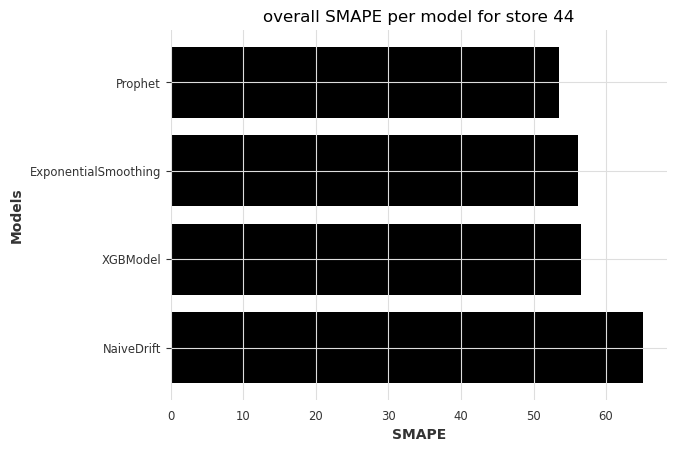

In [40]:
plt.barh(grouped_df_results.sort_values(by='Improvement', ascending=True)["Model"],
         grouped_df_results.sort_values(by='Improvement', ascending=True)["SMAPE"])

# setting label of y-axis
plt.ylabel("Models")
 
# setting label of x-axis
plt.xlabel("SMAPE")
plt.title(f"overall SMAPE per model for store {store_nbr}")

# save the plot
plt.savefig(f'../../data/modeling_results_plotted/store_{store_nbr}_best_performing_models.png')

plt.show()




### Capture the best model for this store, and show the improvement over the Naive model

In [41]:
#capture the best model name
best_model = grouped_df_results.sort_values(by='Improvement', ascending=False).reset_index().loc[0, "Model"]
#capture the best model's improvement
best_model_improvement = grouped_df_results.sort_values(by='Improvement', ascending=False).reset_index().loc[0, "Improvement"]


# Print message stating which model is the best, and how it compares to naive
print(f"The best model for store {store_nbr} is {best_model}")
print(f"the improvement over the Naive model is  {round(best_model_improvement * 100,2)}%")


The best model for store 44 is Prophet
the improvement over the Naive model is  17.7%


## Save the forecasts to dataframe and write as excel file

In [42]:
#Reduce the dataframe to only include the best performing model (== model selection is dynamic, best model is selected based on overall lowest SMAPE)
best_df_results_nmf = df_results_nmf.loc[df_results_nmf['Model'] == best_model]

In [43]:
# Initialize an empty DataFrame with the desired columns:  item, model and 60 days ahead forecasts
forecast_df = pd.DataFrame(columns=["Item", "Model"] + [f"day_t+{i}" for i in range(1, 61)])

In [44]:
# Iterate over each row in the  DataFrame with the best model and extract the forecasts from the series objects:

for index, row in best_df_results_nmf.iterrows():
    Item = row["Item"]
    Model = row["Model"]
    Forecast_series = row["Forecast"].pd_dataframe()
    Forecast_series = Forecast_series["unit_sales"]
    
    # Extract the forecasts from the series object as a list
    forecasts = Forecast_series.to_list()
    
    # Create a new row with item, model, and the forecasts for each day
    new_row = {"Item": Item, "Model": Model}
    for i in range(len(forecasts)):
        new_row[f"day_t+{i+1}"] = forecasts[i]
    
    # Append the new row to the new DataFrame
    forecast_df = forecast_df.append(new_row, ignore_index=True)

# print(forecast_df.head())

# best_df_results_nmf["Forecast"]

In [45]:
# forecast_df

#### Write this dataframe to excel for use by the store managers

In [46]:
# Save the forecasts to file folder on Github
forecast_df.to_excel(f'../../data/forecasted_unit_sales/store_{store_nbr}_forecasts.xlsx', index=False)


## 12.5  Plot the performance of the modeled timeseries

in the second cell of this paragraph, please specify which model you want to plot.
The first cell will show the possible options.

In [47]:
# print("Choose which of the folowing model(s) you want to plot")
# print(df_results_nmf['Model'].unique())

In [48]:
# model_to_plot = input("Which of the above models would you like to see? : ")
model_to_plot = best_model   # We plot the best performing model
naivemodel = NaiveDrift      # define the naive model

In [49]:
naive_model_df = df_results_nmf[df_results_nmf['Model'] == "NaiveDrift"]

In [50]:
single_model_df = df_results_nmf[df_results_nmf['Model'] == model_to_plot]

In [51]:
import seaborn as sns

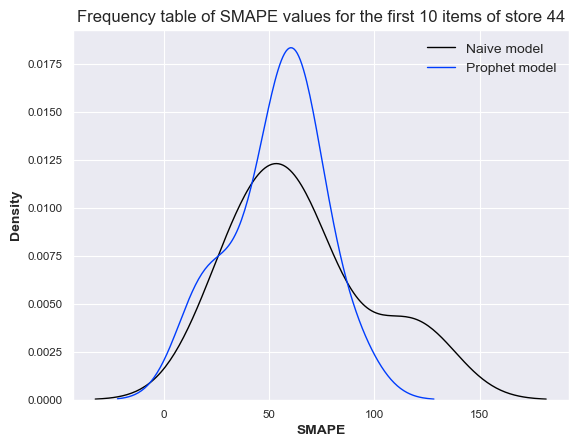

In [52]:
sns.set_style('darkgrid')

# Create a new figure and axis
fig, ax = plt.subplots()

# Overlay the first graph
sns.kdeplot(naive_model_df["SMAPE"], ax=ax, label=f'Naive model')

# Overlay the second graph
sns.kdeplot(single_model_df["SMAPE"], ax=ax, label=f'{model_to_plot} model')

# Set the title and legend
ax.set(title=f'Frequency table of SMAPE values for the first {items_to_model} items of store {store_nbr}')
ax.legend()

# Save the figure as PNG
plt.savefig(f'../../data/modeling_results_plotted/store_{store_nbr}_SMAPE_frequencyplot.png', dpi=300)

In [ ]:
# sns.set_style('darkgrid')

# sns.distplot(naive_model_df["SMAPE"]).set(title=f'Frequency table of SMAPE values of {NaiveSeasonal()} model, for the first {items_to_model} items of store {store_nbr}')
# sns.distplot(single_model_df["SMAPE"]).set(title=f'Frequency table of SMAPE values of {model_to_plot} model (blue) \n vs Naive model (grey), \n for the first {items_to_model} items of store {store_nbr}')


## To do:

* ~De forecasts wegschrijven in een excel file voor de supermarkt managers~
* Visual van 1 of 2 forecast maken
* ~Visual van improvements (barchart)~
* ~Dynamisch het beste model selecteren en de SMAPE plotten in frequentie grafiek t.o.v. naive~
* OUTLIERS verwijderen in bestand Joost


/n

* ~Code opschonen~
* Code beschrijven in Markdown en comments


# -------------------------------------------------------